In [373]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting
from nilearn import datasets
import nilearn
import pandas as pd

# Comparing performance of CPMs
### Mean Accuracy over 100 trials as a function of regularization. Comparing connectomes built from MLDL vs HO+S.

In [360]:
with open("../scores_c1-001_tangent.pickle", "rb") as handle:
    scoresMLDL = pickle.load(handle)

with open("scores_HO+S_c1-001_tangent.pickle", "rb") as handle:
    scoresHO_S = pickle.load(handle)

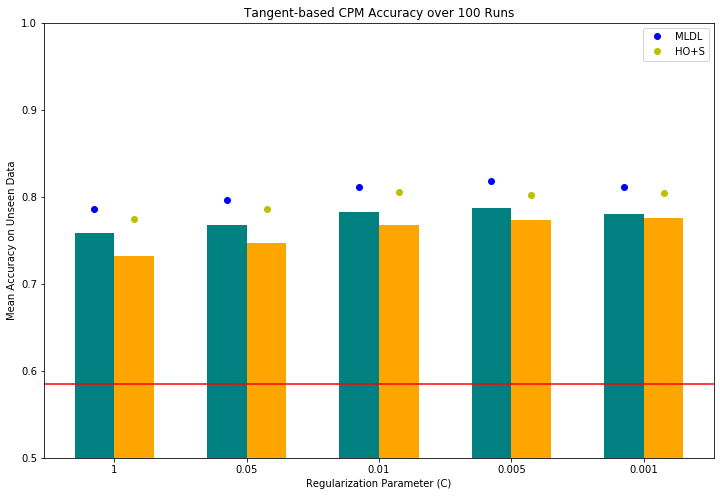

In [361]:
width = .3

for i, c in enumerate(scoresMLDL.keys()):
    plt.plot(i, np.max(scoresMLDL[c]), "ob")
    plt.plot(i+width, np.max(scoresHO_S[c]), "oy")
    plt.bar(i, np.mean(scoresMLDL[c]), width, color = 'teal')
    plt.bar(i+width, np.mean(scoresHO_S[c]), width, color = 'orange')


plt.ylim([.5, 1])
plt.xticks(np.arange(0, 5) + width /2, (scoresMLDL.keys()))
plt.legend(['MLDL', 'HO+S'])
plt.title("Tangent-based CPM Accuracy over 100 Runs")
plt.xlabel("Regularization Parameter (C)")
plt.ylabel("Mean Accuracy on Unseen Data")
plt.axhline(y=0.585, color='r', linestyle='-')

fig = plt.gcf()
fig.set_size_inches(12, 8)

### Look at the average SVM weights between the two CPMs

In [362]:
with open("../weights_c1-001_tangent.pickle", "rb") as handle:
    weightsMLDL = pickle.load(handle)

with open("weights_HO+S_c1-001_tangent.pickle", "rb") as handle:
    weightsHO_S = pickle.load(handle)

mldl_nroi = 162
ho_s_nroi = 121



### Plot Connectomes

C1	MLDL	0.02910555906679607 HO+S	0.04515787930453166
C0.05	MLDL	0.02412793293465826 HO+S	0.034668662808346455
C0.01	MLDL	0.015528203630326249 HO+S	0.020516551784182668
C0.005	MLDL	0.011599808264786864 HO+S	0.01502250654960672
C0.001	MLDL	0.005022105526123947 HO+S	0.0064948207218716095


Text(0.5, 1, 'CPM-HO+S Average SVM Weights\n0.01')

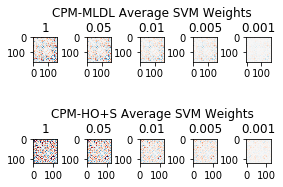

In [371]:
fig, axs = plt.subplots(2, 5)

for i, c in enumerate(weightsMLDL.keys()):
    # MLDL
    arr_mldl = np.zeros((mldl_nroi, mldl_nroi))
    indices = np.tril_indices(mldl_nroi)
    arr_mldl[indices] = np.mean(weightsMLDL[c], axis = 0)

    arr_mldl = arr_mldl + arr_mldl.T
    np.fill_diagonal(arr_mldl, 0)
    axs[0, i].imshow(arr_mldl, vmin = -0.1, vmax = 0.1)
    axs[0, i].set_title(c)


    # HOS
    arr_ho_s = np.zeros((ho_s_nroi, ho_s_nroi))
    indices = np.tril_indices(ho_s_nroi)
    arr_ho_s[indices] = np.mean(weightsHO_S[c], axis = 0)

    arr_ho_s = arr_ho_s + arr_ho_s.T
    np.fill_diagonal(arr_ho_s, 0)
    axs[1, i].imshow(arr_ho_s, vmin = -0.1, vmax = 0.1)
    axs[1, i].set_title(c)
    print("C{}\tMLDL\t{} HO+S\t{}".format(c, np.std(arr_mldl), np.std(arr_ho_s)))


fig = plt.gcf()
fig.set_size_inches(4, 3)
plt.savefig("CPM_avgweights_connectome.png")
plt.tight_layout(w_pad=0)
axs[0, 2].set_title("CPM-MLDL Average SVM Weights\n0.01")
axs[1, 2].set_title("CPM-HO+S Average SVM Weights\n0.01")


In [364]:
mldl = nib.load("/mnt/chrastil/lab/users/rob/projects/MachineLearning/MLDL_162_thr25_regions.nii.gz")

ho = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-2mm')
ho_filename = ho.maps
ho_labels = ho.labels

schaefer = datasets.fetch_atlas_schaefer_2018(n_rois = 100, resolution_mm = 2)
schaefer_filename = schaefer.maps
schaefer_labels = schaefer.labels


In [367]:
# Get coordinates
s_coords = plotting.find_parcellation_cut_coords(schaefer_filename)
ho_coords = plotting.find_parcellation_cut_coords(ho_filename)
hos_coords = np.concatenate([s_coords, ho_coords])
# mldl_coords = plotting.find_probabilistic_atlas_cut_coords(mldl)

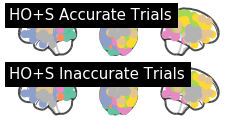

In [372]:

pos_hos = arr_ho_s.copy()
pos_hos[pos_hos < 0] = 0
neg_hos = arr_ho_s.copy()
neg_hos[neg_hos > 0] = 0

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4, 2), facecolor = "white")

plotting.plot_connectome(pos_hos, hos_coords, title = "HO+S Accurate Trials", edge_threshold = "90%", display_mode = "lzr", axes = axes.flatten()[0], edge_cmap = "BrBG")
plotting.plot_connectome(neg_hos, hos_coords, title = "HO+S Inaccurate Trials", edge_threshold = "90%", display_mode = 'lzr', axes = axes.flatten()[1], edge_cmap = "BrBG_r")

In [439]:
# Create hos labels
s_lab = [str(i).split("7Networks_")[-1].strip("'") for i in schaefer.labels]
ho_lab = ho.labels[1:len(ho.labels)]

ho_group_label = [str(i).split()[-1] for i in ho_lab]
s_group_label = [str(i).split("_")[-2] for i in s_lab]

hos_labels = s_lab + ho_lab
hos_group_labels = s_group_label + ho_group_label

In [539]:
# Create pandas dataframe of connectome edge values
hos_node_strengths = pd.DataFrame({
    "labels": hos_labels,
    "group_labels": hos_group_labels,
    "pos_sqrd_strength": np.sum(pos_hos**2, axis = 0),
    "neg_sqrd_strength": np.sum(neg_hos**2, axis = 0),
    "comb_sqrd_strength": np.sum(pos_hos**2, axis = 0) + np.sum(neg_hos**2, axis = 0),
    "pos_magnitude": np.linalg.norm(pos_arr, axis = 0),
    "neg_magnitude": np.linalg.norm(neg_arr, axis = 0),
    "comb_magnitude":np.linalg.norm(pos_arr, axis = 0) + np.linalg.norm(neg_arr, axis = 0)
})

In [540]:
hos_node_strengths

,labels,group_labels,pos_sqrd_strength,neg_sqrd_strength,comb_sqrd_strength,pos_magnitude,neg_magnitude,comb_magnitude
0,LH_Vis_1,Vis,0.000697,0.001116,0.001813,0.101099,0.112225,0.213324
1,LH_Vis_2,Vis,0.003031,0.003511,0.006541,0.178455,0.193473,0.371928
2,LH_Vis_3,Vis,0.001637,0.003698,0.005336,0.150916,0.193329,0.344244
3,LH_Vis_4,Vis,0.004296,0.004779,0.009075,0.198624,0.186614,0.385238
4,LH_Vis_5,Vis,0.009658,0.008589,0.018246,0.277992,0.280495,0.558487
...,...,...,...,...,...,...,...,...
116,Right Putamen,Putamen,0.000620,0.002078,0.002698,0.117512,0.153032,0.270544
117,Right Pallidum,Pallidum,0.000969,0.000391,0.001359,0.153046,0.087113,0.240160
118,Right Hippocampus,Hippocampus,0.000734,0.000684,0.001418,0.118770,0.097502,0.216272
119,Right Amygdala,Amygdala,0.000961,0.001096,0.002058,0.139893,0.140407,0.280300


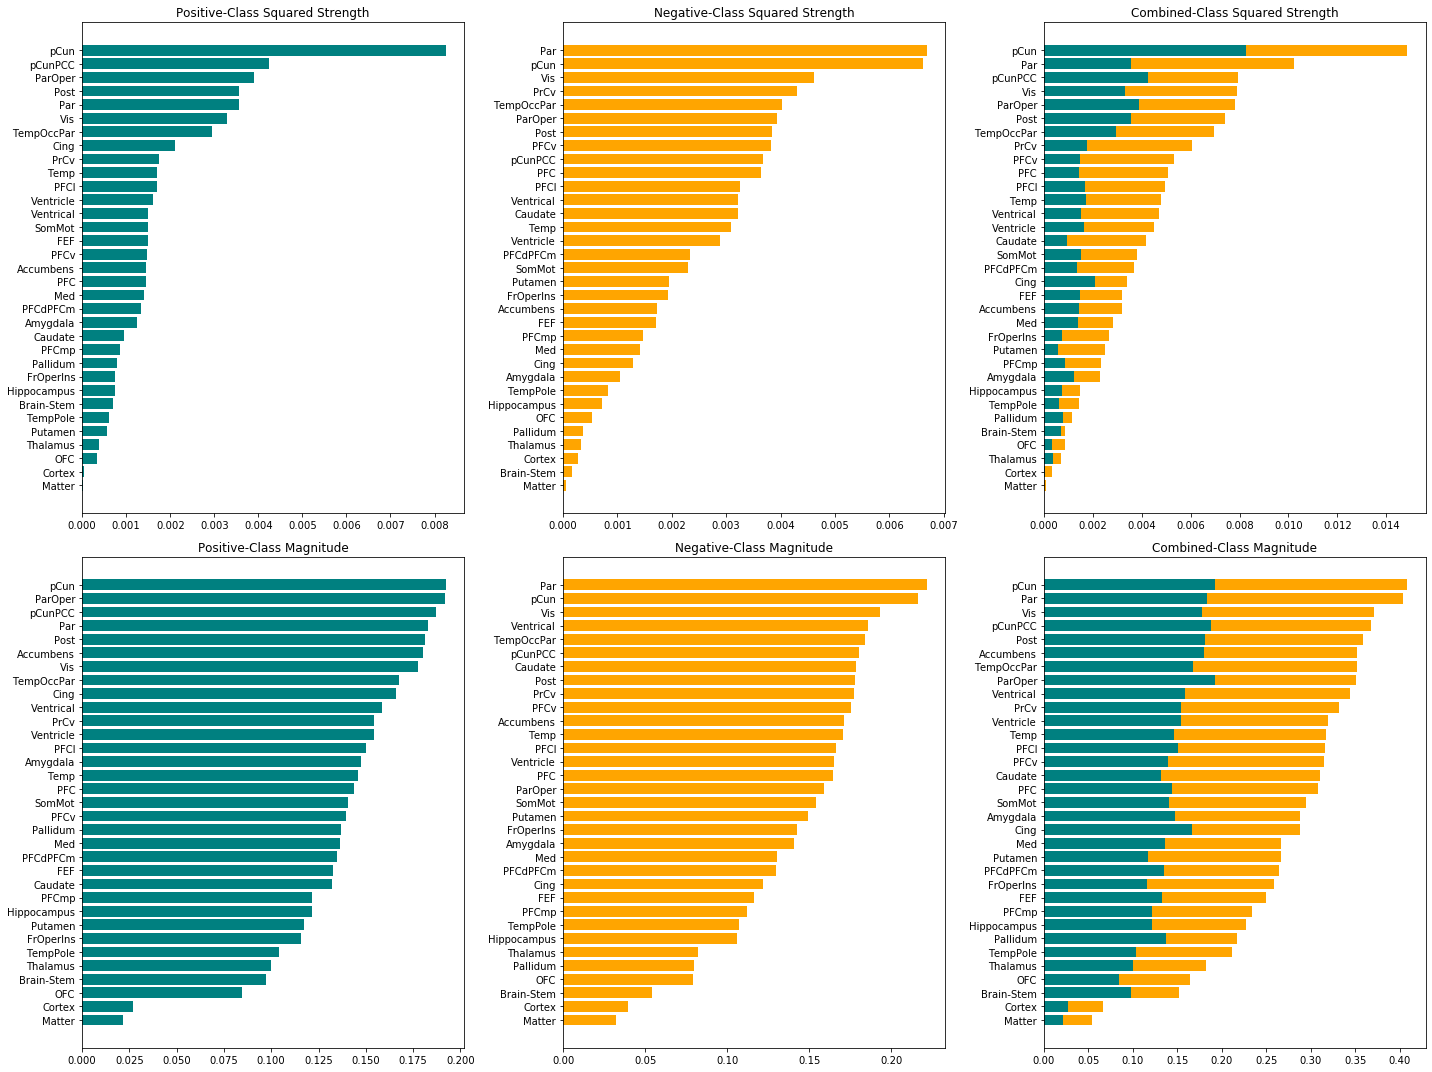

In [557]:
groupmean_sort_by = {}
df_mean = hos_node_strengths.groupby("group_labels").mean()
fig, axs = plt.subplots(2, 3, figsize = (20, 15), facecolor = 'white')

for i, col in enumerate(hos_node_strengths.columns):
    if i > 1: 
        groupmean_sort_by[col] = df_mean.sort_values(col)

# Pos sqrd strength
axs[0, 0].barh(groupmean_sort_by['pos_sqrd_strength'].index, groupmean_sort_by['pos_sqrd_strength']['pos_sqrd_strength'], color = 'teal')
axs[0, 0].set_title('Positive-Class Squared Strength')
# Neg sqrd strength
axs[0, 1].barh(groupmean_sort_by['neg_sqrd_strength'].index, groupmean_sort_by['neg_sqrd_strength']['neg_sqrd_strength'], color = 'orange')
axs[0, 1].set_title('Negative-Class Squared Strength')
# Comb sqrd strength
axs[0, 2].barh(groupmean_sort_by['comb_sqrd_strength'].index, groupmean_sort_by['comb_sqrd_strength']['pos_sqrd_strength'], color = 'teal')
axs[0, 2].barh(groupmean_sort_by['comb_sqrd_strength'].index, groupmean_sort_by['comb_sqrd_strength']['neg_sqrd_strength'], 
               left = groupmean_sort_by['comb_sqrd_strength']['pos_sqrd_strength'], color = 'orange')
axs[0, 2].set_title("Combined-Class Squared Strength")


# Pos Magnitude
axs[1, 0].barh(groupmean_sort_by['pos_magnitude'].index, groupmean_sort_by['pos_magnitude']['pos_magnitude'], color = 'teal')
axs[1, 0].set_title('Positive-Class Magnitude')
# Neg Magnitude
axs[1, 1].barh(groupmean_sort_by['neg_magnitude'].index, groupmean_sort_by['neg_magnitude']['neg_magnitude'], color = 'orange')
axs[1, 1].set_title('Negative-Class Magnitude')
# Comb Magnitude
axs[1, 2].barh(groupmean_sort_by['comb_magnitude'].index, groupmean_sort_by['comb_magnitude']['pos_magnitude'], color = 'teal')
axs[1, 2].barh(groupmean_sort_by['comb_magnitude'].index, groupmean_sort_by['comb_magnitude']['neg_magnitude'], 
               left = groupmean_sort_by['comb_magnitude']['pos_magnitude'], color = 'orange')
axs[1, 2].set_title('Combined-Class Magnitude')
plt.gcf().tight_layout()
    

### Schaefer label abreviations can be found here:
https://github.com/ThomasYeoLab/CBIG/blob/master/stable_projects/brain_parcellation/Yeo2011_fcMRI_clustering/1000subjects_reference/Yeo_JNeurophysiol11_SplitLabels/Yeo2011_7networks_N1000.split_components.glossary.csv

In [561]:
groupmean_sort_by['comb_magnitude']

,pos_sqrd_strength,neg_sqrd_strength,comb_sqrd_strength,pos_magnitude,neg_magnitude,comb_magnitude
group_labels,,,,,,
Matter,0.000018,0.000056,0.000073,0.021358,0.032269,0.053627
Cortex,0.000042,0.000270,0.000312,0.026936,0.039613,0.066550
Brain-Stem,0.000698,0.000161,0.000859,0.097407,0.053883,0.151291
OFC,0.000332,0.000524,0.000856,0.084655,0.079238,0.163893
Thalamus,0.000378,0.000332,0.000710,0.099849,0.082190,0.182039
TempPole,0.000608,0.000833,0.001441,0.103899,0.106948,0.210847
Pallidum,0.000789,0.000367,0.001156,0.137001,0.079631,0.216632
Hippocampus,0.000746,0.000719,0.001465,0.121305,0.106001,0.227307
PFCmp,0.000859,0.001471,0.002330,0.121725,0.111949,0.233674
